# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Nihal Ezgi Yücetürk"
student2 = "Atakan Büyükoğlu"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.initializers import RandomNormal
from keras.callbacks import Callback

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', #deleted +1 after label_mapping[j]
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

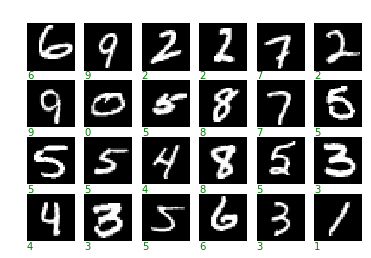

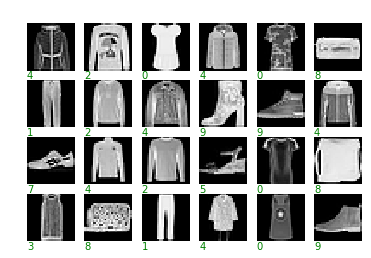

In [4]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

plot_some_samples(x_train, y_train);

plot_some_samples(x_fashion_train, y_fashion_train);

Answer to question 2:
Numbers in green indicate the true image labels

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [7]:
# Define all callback classes to be used for early stopping
# For all classes,
# Epsilon is the threshold parameter
# Percentage is optional, but is a percent threshold to be checked if entered, input 0.01 means 1%

class stopAtValAccDecrease(Callback):
# If validation accuracy drops more than epsilon in value in the next epoch training stops
# If validation accuracy drops more than a particular percentage of the current accuracy in the next epoch training stops
    def __init__(self, eps = 0.1, perc = None):
        self.eps = eps
        self.prev_acc = 0
        self.perc = perc
    
    def on_epoch_end(self, epoch, logs={}):
        #loss = logs.get('loss')
        acc = logs.get('val_acc')
        if ( self.prev_acc - acc) >= self.eps or ( self.perc is not None and self.prev_acc / acc - 1 >= self.perc ):
            self.model.stop_training = True
            self.prev_acc = 0
            print('Stopped due to High Validation Accuracy Decrease')
        else:
            self.prev_acc = acc
            

class stopAtValLossIncrease(Callback):
# If validation loss increases more than epsilon in value in the next epoch training stops

    def __init__(self, eps = 0.1, perc = None):
        self.eps = eps
        self.prev_loss = np.Infinity
        self.perc = perc
    
    def on_epoch_end(self, epoch, logs={}):
        #loss = logs.get('loss')
        loss = logs.get('val_loss')
        if (loss - self.prev_loss) >= self.eps or ( self.perc is not None and loss / self.prev_loss - 1 >= self.perc ):
            self.model.stop_training = True
            self.prev_loss = np.Infinity
            print('Stopped due to High Validation Loss Increase')
        else:
            self.prev_loss = loss

                
class stopAtTraValLossDiff(Callback):
# If difference between training loss and validation loss is more than epsilon in value training stops

    def __init__(self, eps = 0.1, perc = None):
        self.eps = eps
        self.perc = perc

    def on_epoch_end(self, epoch, logs={}):
        val_loss = logs.get('val_loss')
        tra_loss = logs.get('loss')
        if (val_loss - tra_loss) >= self.eps or ( self.perc is not None and val_loss / tra_loss - 1 >= self.perc ):
            self.model.stop_training = True
            print('Stopped due to High Training-Validation Loss Difference')
                
                
class stopAtTraValAccDiff(Callback):
# If difference between training accuracy and validation accuracy is more than epsilon in value training stops

    def __init__(self, eps = 0.1, perc = None):
        self.eps = eps
        self.perc = perc

    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs.get('val_acc')
        tra_acc = logs.get('acc')
        if (tra_acc - val_acc) >= self.eps or ( self.perc is not None and tra_acc / val_acc - 1 >= self.perc ):
            self.model.stop_training = True
            print('Stopped due to High Training-Validation Accuracy Difference')

                
class stopAtStableLoss(Callback):
# If training drops less than epsilon in value in the next epoch training stops
    def __init__(self, eps = 0.001, perc = None):
        self.eps = eps
        self.prev_loss = np.Infinity
        self.perc = perc
    
    def on_epoch_end(self, epoch, logs={}):
        #loss = logs.get('loss')
        loss = logs.get('loss')
        if (self.prev_loss - loss) <= self.eps or ( self.perc is not None and 1 - loss / self.prev_loss <= self.perc ):
            self.model.stop_training = True
            self.prev_loss = np.Infinity
            print('Stopped due to Too Stable Loss')
        else:
            self.prev_loss = loss

In [8]:
#Initialize model parameters
num_classes = 10
in_shape = x_train[0].shape
batch_size = 128
epochs = 50

In [9]:
# Define the callback instances
def call_callbacks():
    callbacks = [stopAtValAccDecrease(eps = 0.02),
             stopAtValLossIncrease(eps = 5, perc = 0.02),
             stopAtTraValLossDiff(eps = 5, perc = 0.15),
             stopAtTraValAccDiff(eps = 0.03),
             stopAtStableLoss(eps = 0, perc = 0.005) ]
    
    return callbacks


In [10]:
# Softmax activation for the output layer.
# Categorical crossentropy loss.
# Accuracy metric to the metrics.
# Stochastic gradient descent for the optimizer.
# Minibatch size of 128.

model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=in_shape))
#model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [11]:
# For this example, we used part of the training data as validation data for more robust comparison reasons
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_split = 0.15 )


Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 1s 13us/step - loss: 1.3220 - acc: 0.6809 - val_loss: 0.8409 - val_acc: 0.8377
Epoch 2/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.7685 - acc: 0.8271 - val_loss: 0.6195 - val_acc: 0.8659
Epoch 3/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.6283 - acc: 0.8507 - val_loss: 0.5297 - val_acc: 0.8796
Epoch 4/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.5598 - acc: 0.8621 - val_loss: 0.4797 - val_acc: 0.8862
Epoch 5/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.5179 - acc: 0.8691 - val_loss: 0.4472 - val_acc: 0.8907
Epoch 6/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.4890 - acc: 0.8737 - val_loss: 0.4245 - val_acc: 0.8933
Epoch 7/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.4676 - acc: 0.8780 - val_loss: 0.4076 - val_acc:

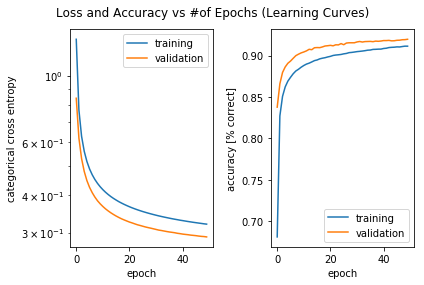

In [12]:
plot_history(history, "Loss and Accuracy vs #of Epochs (Learning Curves)");

In [13]:
def misclassed_incides(model, x_test, y_test):
    pred_y = model.predict_classes(x_test)
    y_orig = np.argmax(y_test, axis=1)
    if len(pred_y)!= len(y_orig):
        raise ValueError('LEnght mismatch')
    err = np.nonzero(pred_y - y_orig)[0]
    plot_some_samples(x_test, y_orig, pred_y, select_from=err)

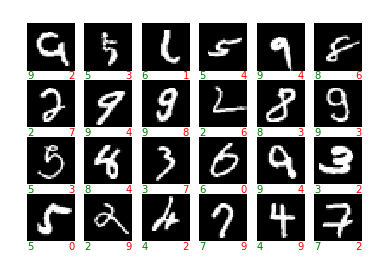

In [14]:
misclassed_incides(model, x_test, y_test)

In [15]:
# Same model defined for the MNIST Fashion Dataset

# Softmax activation for the output layer.
# Categorical crossentropy loss.
# Accuracy metric to the metrics.
# Stochastic gradient descent for the optimizer.
# Minibatch size of 128.

model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=in_shape))
#model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [16]:
# For this example, we used part of the training data as validation data for more robust comparison reasons
history = model.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_split = 0.15 )


Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 1s 13us/step - loss: 1.2106 - acc: 0.6333 - val_loss: 0.8879 - val_acc: 0.7218
Epoch 2/50
51000/51000 [==============================] - 1s 11us/step - loss: 0.8099 - acc: 0.7428 - val_loss: 0.7460 - val_acc: 0.7631
Epoch 3/50
51000/51000 [==============================] - 1s 11us/step - loss: 0.7155 - acc: 0.7742 - val_loss: 0.6844 - val_acc: 0.7791
Epoch 4/50
51000/51000 [==============================] - 1s 11us/step - loss: 0.6653 - acc: 0.7895 - val_loss: 0.6461 - val_acc: 0.7927
Epoch 5/50
51000/51000 [==============================] - 1s 12us/step - loss: 0.6326 - acc: 0.7993 - val_loss: 0.6204 - val_acc: 0.8011
Epoch 6/50
51000/51000 [==============================] - 1s 11us/step - loss: 0.6088 - acc: 0.8062 - val_loss: 0.6002 - val_acc: 0.8034
Epoch 7/50
51000/51000 [==============================] - 1s 11us/step - loss: 0.5906 - acc: 0.8109 - val_loss: 0.5856 - val_acc:

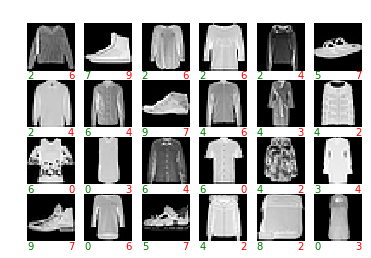

In [17]:
misclassed_incides(model, x_fashion_test, y_fashion_test)

Answer to question 10: Green ones are the true labels of the data points whereas the red ones are what our model predicted for the corresponding data points.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [18]:
# Part 1
def model_Q3(in_shape, num_hidden = 128, act = 'relu'):
    # Create the model
    # One hidden layer with 128 units and the 'relu' activation
    model = Sequential()

    # Add the layers
    model.add(Dense(num_hidden, activation=act , input_shape=in_shape))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_Q3(in_shape).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Different learning rates
lr_list = np.arange(0.01,0.11,0.01)
batch_size = 128
epochs = 50

In [20]:
# Part 2
# Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD)

sgd_hist_list = []
for lr_ in lr_list:
    # Alter the learning rate parameter of the model
    sgd = SGD(lr=lr_)
    model = model_Q3(x_train[0].shape)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


    # Fit the model
    history_sgd = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks = None, validation_data = (x_test, y_test) )
    
    sgd_hist_list.append(history_sgd.history)


In [21]:
# Part 3
# Replace the stochastic gradient descent optimizer with the Adam optimizer 
# Fit the model for 50 epochs with different learning rates of Adam (SGD)

adm_hist_list = []
for lr_ in lr_list:
    # Alter the learning rate parameter of the model
    adm = Adam(lr=lr_/10)
    model = model_Q3(x_train[0].shape)
    model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])
    # Fit the model
    history_adam = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks = None, validation_data = (x_test, y_test) )
    
    adm_hist_list.append(history_adam.history)


In [22]:
# Part 4
# Chosen history is the one which returns the highest accuracy among all trainins for SGD and Adam independently
sgd_val_list = [x['val_acc'][-1] for x in sgd_hist_list] 
adm_val_list = [x['val_acc'][-1] for x in adm_hist_list] 
sgd_hist = sgd_hist_list[np.argmax(sgd_val_list)]
adm_hist = adm_hist_list[np.argmax(adm_val_list)]

In [23]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    fig.set_figheight(8)
    fig.set_figwidth(13)
    
    ax1.plot(history_sgd['loss'], label=label1 + ' training' )
    ax1.plot(history_sgd['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam['loss'], label=label2 + ' training')
    ax1.plot(history_adam['val_loss'], label=label2 + ' validation')
    ax1.legend(loc='lower left')
    
    ax2.plot(history_sgd['acc'], label=label1 + ' training')
    ax2.plot(history_sgd['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam['acc'], label=label2 + ' training')
    ax2.plot(history_adam['val_acc'], label=label2 + ' validation')
    ax2.legend(loc='lower left')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

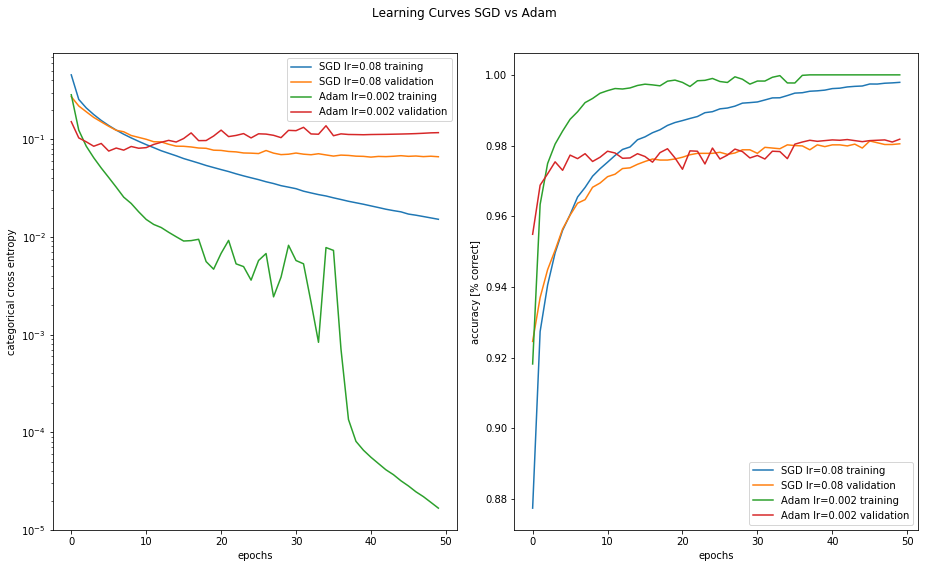

In [24]:
comparison_plot(sgd_hist, adm_hist, 'SGD lr=0.08', 'Adam lr=0.002', 'Learning Curves SGD vs Adam' );

In [25]:
# Part 6
# Implementing the Adam optimizer to the Fashion MNIST dataset

adm = Adam(lr=0.002)
model = model_Q3(x_fashion_train[0].shape)
model.compile(loss='categorical_crossentropy',
          optimizer=adm,
          metrics=['accuracy'])
# Fit the model
print(x_fashion_train.shape)
history_adam = model.fit(x_fashion_train, y_fashion_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks = None, validation_data = (x_fashion_test, y_fashion_test) )

(60000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.5137 - acc: 0.8192 - val_loss: 0.4460 - val_acc: 0.8437
Epoch 2/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.3832 - acc: 0.8637 - val_loss: 0.3872 - val_acc: 0.8621
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.3445 - acc: 0.8752 - val_loss: 0.3690 - val_acc: 0.8689
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.3184 - acc: 0.8839 - val_loss: 0.4003 - val_acc: 0.8557
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.3051 - acc: 0.8879 - val_loss: 0.3696 - val_acc: 0.8641
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2873 - acc: 0.8940 - val_loss: 0.3500 - val_acc: 0.8736
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2777 - acc: 0.8968 - val_loss: 0.3

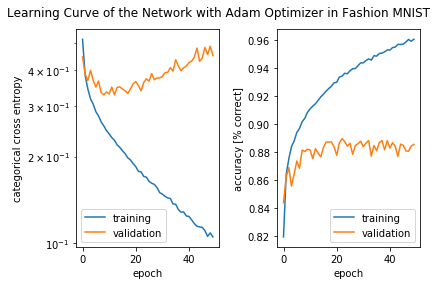

In [26]:
#Plotting the results of Adam optimizer on Fashion MNIST
plot_history(history_adam, 'Learning Curve of the Network with Adam Optimizer in Fashion MNIST');

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A)It overshoots the minimum of the error function and loss starts to fluctuate after some epochs.

B)It takes very long time (too much epochs) for SGD to converge the minimum of the error curve.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: It starts overfitting apporoximately after 20th epoch for best learning rate (0.002). 

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For loss curves, training loss approaches to zero when number of epochs increases so does validation loss but validation loss starts to increase again when overfitting begins. For accuracy curves, both increases until overfitting begins. Training accuracy approaches to 100 while validation accuracy stays stable or decreases.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [27]:
# Part 1

#The number of neurons in the hidden layers
neuron_counts = [10, 100, 250, 500, 1000]
adm = Adam(lr= 0.001)
batch_size = 128
epochs = 20


#Keep history for the next part
histories = []

# Fit the model for different hidden neuron counts
for num_hidden in neuron_counts:
    # Create the model
    model = model_Q3(x_train[0].shape,  num_hidden = num_hidden)
    # Add the optimization parameters to the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=adm,
                  metrics=['accuracy'])
    
    # Model summary
    model.summary()
    # Fit the model
    
    histories.append( model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_data = (x_test, y_test) )
                    )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_48 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 23us/step - loss: 0.7357 - acc: 0.7925 - val_loss: 0.3692 - val_acc: 0.8951
Epoch 2/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.3391 - acc: 0.9037 - val_loss: 0.3019 - val_acc: 0.9133
Epoch 3/20
60000/60000 [==============================] - 1s 14us/step - loss: 0.2951 - acc: 0.9157 - val_loss: 0.2787 - val_acc: 0.9207
Epoch 4/20
60000/60000 [==============================] - 1s 14us/step - lo

60000/60000 [==============================] - 2s 34us/step - loss: 0.0259 - acc: 0.9931 - val_loss: 0.0658 - val_acc: 0.9801
Epoch 7/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.0203 - acc: 0.9952 - val_loss: 0.0640 - val_acc: 0.9803
Epoch 8/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.0161 - acc: 0.9965 - val_loss: 0.0666 - val_acc: 0.9803
Epoch 9/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.0125 - acc: 0.9973 - val_loss: 0.0653 - val_acc: 0.9807
Epoch 10/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.0096 - acc: 0.9983 - val_loss: 0.0654 - val_acc: 0.9804
Epoch 11/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.0080 - acc: 0.9984 - val_loss: 0.0677 - val_acc: 0.9812
Epoch 12/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0062 - acc: 0.9991 - val_loss: 0.0740 - val_acc: 0.9801
Epoch 13/20
60000/60000 [========================

60000/60000 [==============================] - 9s 143us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0757 - val_acc: 0.9824
Epoch 17/20
60000/60000 [==============================] - 9s 142us/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.0652 - val_acc: 0.9848
Epoch 18/20
60000/60000 [==============================] - 8s 141us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0738 - val_acc: 0.9836
Epoch 19/20
60000/60000 [==============================] - 8s 141us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0801 - val_acc: 0.9818
Epoch 20/20
60000/60000 [==============================] - 8s 142us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0869 - val_acc: 0.9823


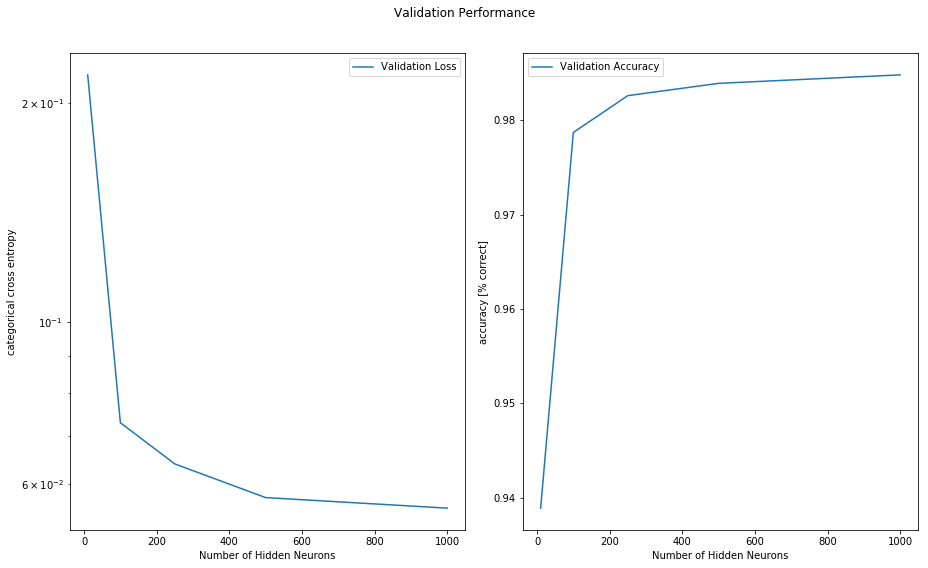

In [28]:
# Part 2

# Variables to hold minimum validation loss and maximum validation accuracy 
val_loss_max = []
val_acc_max = []

for history in histories:
    val_loss_max.append(min(history.history['val_loss']))
    val_acc_max.append(max(history.history['val_acc']))
    
# Plot the results
fig, ax1, ax2 = prepare_standardplot('Validation Performance', 'Number of Hidden Neurons')
fig.set_figheight(8)
fig.set_figwidth(13)
ax1.plot(neuron_counts, val_loss_max, label = "Validation Loss")
ax2.plot(neuron_counts, val_acc_max, label = "Validation Accuracy")
#ax1.set_xscale('log')
#ax2.set_xscale('log')
finalize_standardplot(fig, ax1, ax2)

In [29]:
# Part 3

# Part 1 for Fashion MNIST

#Keep history for the next part
histories = []

# Fit the model for different hidden neuron counts
for num_hidden in neuron_counts:
    # Create the model
    model = model_Q3(x_fashion_train[0].shape,  num_hidden = num_hidden)
    # Add the optimization parameters to the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=adm,
                  metrics=['accuracy'])
    
    # Model summary
    model.summary()
    # Fit the model
    
    histories.append( model.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_data = (x_fashion_test, y_fashion_test) )
                    )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_58 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.6577 - acc: 0.7642 - val_loss: 0.5322 - val_acc: 0.8172
Epoch 2/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.4779 - acc: 0.8366 - val_loss: 0.5063 - val_acc: 0.8255
Epoch 3/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.4464 - acc: 0.8469 - val_loss: 0.4709 - val_acc: 0.8367
Epoch 4/20
60000/60000 [==============================] - 1s 15us/step - lo

60000/60000 [==============================] - 2s 35us/step - loss: 0.2730 - acc: 0.8997 - val_loss: 0.3299 - val_acc: 0.8823
Epoch 7/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2597 - acc: 0.9042 - val_loss: 0.3268 - val_acc: 0.8822
Epoch 8/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2521 - acc: 0.9065 - val_loss: 0.3317 - val_acc: 0.8791
Epoch 9/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.2394 - acc: 0.9109 - val_loss: 0.3355 - val_acc: 0.8810
Epoch 10/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2326 - acc: 0.9134 - val_loss: 0.3426 - val_acc: 0.8806
Epoch 11/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2248 - acc: 0.9173 - val_loss: 0.3187 - val_acc: 0.8883
Epoch 12/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.2176 - acc: 0.9194 - val_loss: 0.3194 - val_acc: 0.8858
Epoch 13/20
60000/60000 [========================

60000/60000 [==============================] - 9s 144us/step - loss: 0.1739 - acc: 0.9352 - val_loss: 0.3367 - val_acc: 0.8941
Epoch 17/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.1697 - acc: 0.9360 - val_loss: 0.3509 - val_acc: 0.8811
Epoch 18/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.1623 - acc: 0.9386 - val_loss: 0.3470 - val_acc: 0.8880
Epoch 19/20
60000/60000 [==============================] - 8s 141us/step - loss: 0.1577 - acc: 0.9414 - val_loss: 0.3411 - val_acc: 0.8931
Epoch 20/20
60000/60000 [==============================] - 9s 142us/step - loss: 0.1513 - acc: 0.9436 - val_loss: 0.3217 - val_acc: 0.8967


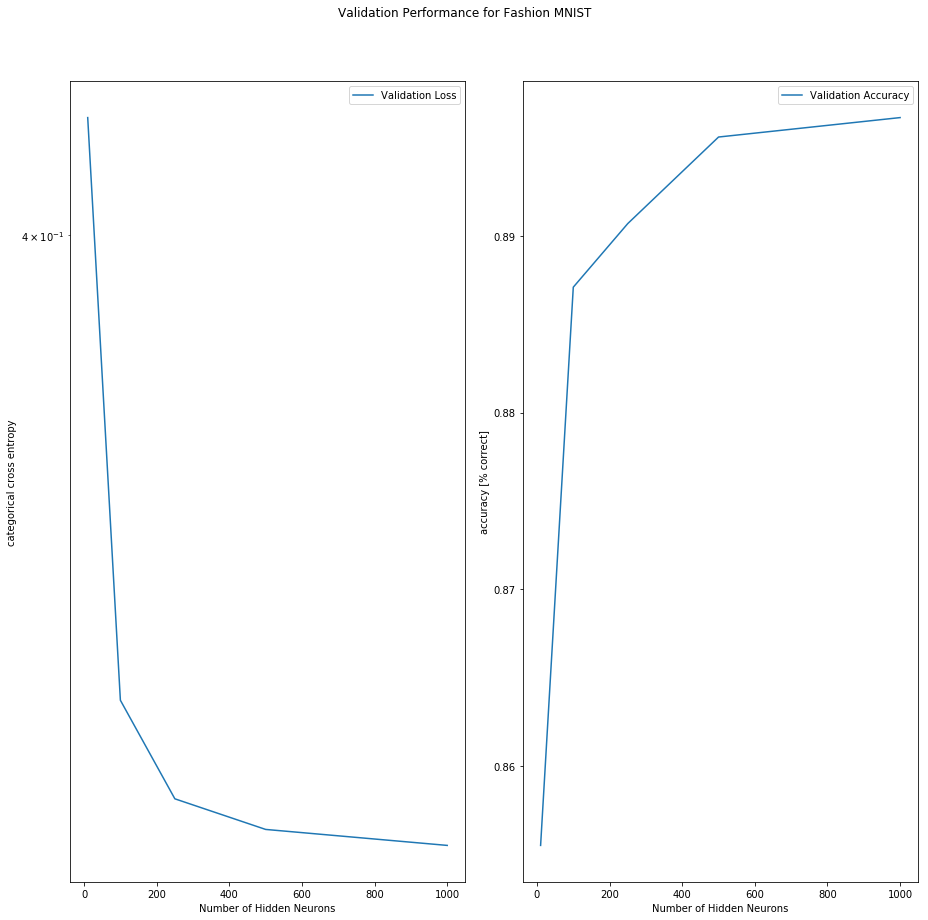

In [30]:
# Part 2 for Fashion MNIST

# Variables to hold minimum validation loss and maximum validation accuracy 
val_loss_max = []
val_acc_max = []

for history in histories:
    val_loss_max.append(min(history.history['val_loss']))
    val_acc_max.append(max(history.history['val_acc']))
    
# Plot the results
fig, ax1, ax2 = prepare_standardplot('Validation Performance for Fashion MNIST', 'Number of Hidden Neurons')
fig.set_figheight(13)
fig.set_figwidth(13)
ax1.plot(neuron_counts, val_loss_max, label = "Validation Loss")
ax2.plot(neuron_counts, val_acc_max, label = "Validation Accuracy")
#ax1.set_xscale('log')
#ax2.set_xscale('log')
finalize_standardplot(fig, ax1, ax2)

Answer to question 2(MNIST): The validation loss and accuracy values cannot reach 100% even if we train the model with infinite samples and infinite epochs, so the result deviates from the General Approximation Theorem. The main practical reason for the deviation is that the labels are noisy, the numbers interpreted from an image can differ from one to another, particularly in the borders of the network.

Answer to question 2(Fashion-MNIST):

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [31]:
adm = Adam(lr = 0.001)
num_classes = 10
in_shape = x_fashion_train[0].shape
batch_size = 128
epochs = 100

In [32]:
drop_out = [False, True]
batch_norm = [False, True]
l2_reg= [False, True]

In [33]:
histories = []
models = []
for dr in drop_out:
    for bn in batch_norm:
        for l_2 in l2_reg:
                # Create the model
                model = Sequential()
                if l_2:
                    if bn:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l2()))
                        model.add(BatchNormalization())
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(), 
                                    kernel_regularizer = l2()))
                        model.add(BatchNormalization())
                    else :
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l2()))
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(), 
                                    kernel_regularizer = l2()))
                else:
                    if bn:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(BatchNormalization())
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(BatchNormalization())
                    else:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))            
                
                if dr:
                    model.add(Dropout(0.5))
                
                model.add(Dense(num_classes, activation='softmax'))

                # Add the optimization parameters to the model
                model.compile(loss='categorical_crossentropy',
                      optimizer=adm,
                      metrics=['accuracy'])
                
                hist = model.fit(x_fashion_train,y_fashion_train,
                          batch_size=batch_size,
                          epochs=epochs,
                        verbose=1,
                        callbacks = None, validation_data = (x_fashion_test, y_fashion_test) )
                    
                histories.append(hist.history)
                models.append(model)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 32us/step - loss: 3.5547 - acc: 0.6384 - val_loss: 1.5328 - val_acc: 0.7304
Epoch 2/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.3686 - acc: 0.7454 - val_loss: 1.2963 - val_acc: 0.7433
Epoch 3/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.2386 - acc: 0.7536 - val_loss: 1.2136 - val_acc: 0.7532
Epoch 4/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.1736 - acc: 0.7585 - val_loss: 1.1911 - val_acc: 0.7497
Epoch 5/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.1356 - acc: 0.7626 - val_loss: 1.1251 - val_acc: 0.7538
Epoch 6/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.1007 - acc: 0.7661 - val_loss: 1.0925 - val_acc: 0.7608
Epoch 7/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.0697 - acc: 0.7664 - val_loss: 1.0824 - 

60000/60000 [==============================] - 1s 19us/step - loss: 0.8479 - acc: 0.8011 - val_loss: 0.8513 - val_acc: 0.7964
Epoch 60/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8477 - acc: 0.7992 - val_loss: 0.8873 - val_acc: 0.7896
Epoch 61/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8475 - acc: 0.7994 - val_loss: 0.8705 - val_acc: 0.7883
Epoch 62/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8421 - acc: 0.8007 - val_loss: 0.8765 - val_acc: 0.7869
Epoch 63/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8431 - acc: 0.8017 - val_loss: 0.8683 - val_acc: 0.7883
Epoch 64/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8386 - acc: 0.8020 - val_loss: 0.8610 - val_acc: 0.7983
Epoch 65/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.8405 - acc: 0.7999 - val_loss: 0.8616 - val_acc: 0.7925
Epoch 66/100
60000/60000 [==============

Epoch 18/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.5228 - acc: 0.8521 - val_loss: 0.5748 - val_acc: 0.8282
Epoch 19/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5184 - acc: 0.8521 - val_loss: 0.5723 - val_acc: 0.8284
Epoch 20/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5173 - acc: 0.8529 - val_loss: 0.5415 - val_acc: 0.8440
Epoch 21/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5100 - acc: 0.8541 - val_loss: 0.5344 - val_acc: 0.8433
Epoch 22/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5130 - acc: 0.8517 - val_loss: 0.5488 - val_acc: 0.8393
Epoch 23/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5109 - acc: 0.8537 - val_loss: 0.5378 - val_acc: 0.8458
Epoch 24/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.5066 - acc: 0.8536 - val_loss: 0.5369 - val_acc: 0.8457
Epoch 25/100
60000/60000 [=

60000/60000 [==============================] - 1s 20us/step - loss: 0.4596 - acc: 0.8629 - val_loss: 0.4820 - val_acc: 0.8554
Epoch 77/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4570 - acc: 0.8630 - val_loss: 0.4913 - val_acc: 0.8525
Epoch 78/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4589 - acc: 0.8613 - val_loss: 0.4926 - val_acc: 0.8522
Epoch 79/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4583 - acc: 0.8628 - val_loss: 0.4765 - val_acc: 0.8555
Epoch 80/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4609 - acc: 0.8618 - val_loss: 0.5431 - val_acc: 0.8325
Epoch 81/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4562 - acc: 0.8633 - val_loss: 0.4779 - val_acc: 0.8532
Epoch 82/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4552 - acc: 0.8638 - val_loss: 0.4912 - val_acc: 0.8494
Epoch 83/100
60000/60000 [==============

Epoch 35/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.7393 - acc: 0.8262 - val_loss: 0.8059 - val_acc: 0.8039
Epoch 36/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.7400 - acc: 0.8257 - val_loss: 0.8992 - val_acc: 0.7688
Epoch 37/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7444 - acc: 0.8249 - val_loss: 0.9796 - val_acc: 0.7406
Epoch 38/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7445 - acc: 0.8240 - val_loss: 1.0292 - val_acc: 0.7247
Epoch 39/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.7430 - acc: 0.8264 - val_loss: 0.9945 - val_acc: 0.7415
Epoch 40/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7426 - acc: 0.8254 - val_loss: 0.8484 - val_acc: 0.7883
Epoch 41/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7439 - acc: 0.8260 - val_loss: 0.8399 - val_acc: 0.7957
Epoch 42/100
60000/60000 [=

Epoch 94/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7447 - acc: 0.8264 - val_loss: 0.8825 - val_acc: 0.7848
Epoch 95/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7436 - acc: 0.8245 - val_loss: 1.3185 - val_acc: 0.6443
Epoch 96/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7417 - acc: 0.8267 - val_loss: 0.9508 - val_acc: 0.7672
Epoch 97/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7422 - acc: 0.8254 - val_loss: 1.0134 - val_acc: 0.7501
Epoch 98/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7407 - acc: 0.8263 - val_loss: 0.9591 - val_acc: 0.7470
Epoch 99/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7438 - acc: 0.8244 - val_loss: 0.9988 - val_acc: 0.7406
Epoch 100/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.7397 - acc: 0.8263 - val_loss: 1.0878 - val_acc: 0.6946
Train on 60000 samples, va

60000/60000 [==============================] - 2s 29us/step - loss: 0.3902 - acc: 0.8771 - val_loss: 0.5071 - val_acc: 0.8364
Epoch 53/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.3955 - acc: 0.8744 - val_loss: 0.5229 - val_acc: 0.8309
Epoch 54/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.3958 - acc: 0.8768 - val_loss: 0.5462 - val_acc: 0.8387
Epoch 55/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.3939 - acc: 0.8753 - val_loss: 0.5199 - val_acc: 0.8268
Epoch 56/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.3934 - acc: 0.8779 - val_loss: 0.5679 - val_acc: 0.8062
Epoch 57/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.3946 - acc: 0.8775 - val_loss: 0.5370 - val_acc: 0.8214
Epoch 58/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.3919 - acc: 0.8769 - val_loss: 0.5435 - val_acc: 0.8279
Epoch 59/100
60000/60000 [==============

Epoch 11/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.1676 - acc: 0.7108 - val_loss: 1.1107 - val_acc: 0.7123
Epoch 12/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1561 - acc: 0.7122 - val_loss: 1.0493 - val_acc: 0.7422
Epoch 13/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1524 - acc: 0.7139 - val_loss: 1.0431 - val_acc: 0.7476
Epoch 14/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1443 - acc: 0.7162 - val_loss: 1.0428 - val_acc: 0.7471
Epoch 15/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1370 - acc: 0.7161 - val_loss: 1.0255 - val_acc: 0.7529
Epoch 16/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1273 - acc: 0.7210 - val_loss: 1.0306 - val_acc: 0.7498
Epoch 17/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.1203 - acc: 0.7238 - val_loss: 1.0202 - val_acc: 0.7455
Epoch 18/100
60000/60000 [=

60000/60000 [==============================] - 1s 23us/step - loss: 0.9809 - acc: 0.7612 - val_loss: 0.9090 - val_acc: 0.7785
Epoch 70/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.9824 - acc: 0.7600 - val_loss: 0.9007 - val_acc: 0.7818
Epoch 71/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9811 - acc: 0.7590 - val_loss: 0.8833 - val_acc: 0.7829
Epoch 72/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9833 - acc: 0.7609 - val_loss: 0.9025 - val_acc: 0.7808
Epoch 73/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.9798 - acc: 0.7588 - val_loss: 0.8886 - val_acc: 0.7855
Epoch 74/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9778 - acc: 0.7612 - val_loss: 0.9074 - val_acc: 0.7733
Epoch 75/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9803 - acc: 0.7597 - val_loss: 0.9624 - val_acc: 0.7453
Epoch 76/100
60000/60000 [==============

60000/60000 [==============================] - 1s 24us/step - loss: 0.5842 - acc: 0.8377 - val_loss: 0.5413 - val_acc: 0.8406
Epoch 28/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.5791 - acc: 0.8380 - val_loss: 0.6161 - val_acc: 0.8112
Epoch 29/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.5790 - acc: 0.8383 - val_loss: 0.5252 - val_acc: 0.8475
Epoch 30/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.5741 - acc: 0.8390 - val_loss: 0.5316 - val_acc: 0.8447
Epoch 31/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.5731 - acc: 0.8407 - val_loss: 0.5310 - val_acc: 0.8417
Epoch 32/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.5697 - acc: 0.8407 - val_loss: 0.5315 - val_acc: 0.8461
Epoch 33/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.5715 - acc: 0.8402 - val_loss: 0.5263 - val_acc: 0.8471
Epoch 34/100
60000/60000 [==============

60000/60000 [==============================] - 1s 24us/step - loss: 0.5323 - acc: 0.8488 - val_loss: 0.5325 - val_acc: 0.8411
Epoch 86/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5311 - acc: 0.8493 - val_loss: 0.5198 - val_acc: 0.8402
Epoch 87/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5322 - acc: 0.8476 - val_loss: 0.5098 - val_acc: 0.8439
Epoch 88/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.5271 - acc: 0.8481 - val_loss: 0.5088 - val_acc: 0.8453
Epoch 89/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5259 - acc: 0.8476 - val_loss: 0.4993 - val_acc: 0.8486
Epoch 90/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5326 - acc: 0.8459 - val_loss: 0.5335 - val_acc: 0.8362
Epoch 91/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5302 - acc: 0.8479 - val_loss: 0.5079 - val_acc: 0.8471
Epoch 92/100
60000/60000 [==============

60000/60000 [==============================] - 2s 28us/step - loss: 0.8534 - acc: 0.8063 - val_loss: 1.1873 - val_acc: 0.6995
Epoch 44/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.8518 - acc: 0.8037 - val_loss: 1.2137 - val_acc: 0.7048
Epoch 45/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.8478 - acc: 0.8064 - val_loss: 0.8329 - val_acc: 0.8052
Epoch 46/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.8535 - acc: 0.8056 - val_loss: 0.9410 - val_acc: 0.7726
Epoch 47/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.8627 - acc: 0.8058 - val_loss: 0.9351 - val_acc: 0.7910
Epoch 48/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.8533 - acc: 0.8073 - val_loss: 0.8967 - val_acc: 0.7852
Epoch 49/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.8465 - acc: 0.8080 - val_loss: 1.0719 - val_acc: 0.7072
Epoch 50/100
60000/60000 [==============

60000/60000 [==============================] - 3s 51us/step - loss: 0.9704 - acc: 0.7861 - val_loss: 0.8156 - val_acc: 0.7425
Epoch 2/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.6116 - acc: 0.8271 - val_loss: 0.6610 - val_acc: 0.8052
Epoch 3/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5641 - acc: 0.8373 - val_loss: 0.6925 - val_acc: 0.7790
Epoch 4/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.5442 - acc: 0.8396 - val_loss: 0.5370 - val_acc: 0.8349
Epoch 5/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5242 - acc: 0.8445 - val_loss: 0.5640 - val_acc: 0.8236
Epoch 6/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5199 - acc: 0.8469 - val_loss: 0.6678 - val_acc: 0.8000
Epoch 7/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5197 - acc: 0.8469 - val_loss: 0.7254 - val_acc: 0.7801
Epoch 8/100
60000/60000 [=====================

60000/60000 [==============================] - 2s 29us/step - loss: 0.4770 - acc: 0.8541 - val_loss: 0.5482 - val_acc: 0.8240
Epoch 61/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4713 - acc: 0.8558 - val_loss: 0.6014 - val_acc: 0.8081
Epoch 62/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4724 - acc: 0.8560 - val_loss: 0.5934 - val_acc: 0.8049
Epoch 63/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4722 - acc: 0.8559 - val_loss: 0.5847 - val_acc: 0.8127
Epoch 64/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4750 - acc: 0.8545 - val_loss: 0.5804 - val_acc: 0.8117
Epoch 65/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4690 - acc: 0.8570 - val_loss: 0.5842 - val_acc: 0.8157
Epoch 66/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4702 - acc: 0.8575 - val_loss: 0.5153 - val_acc: 0.8294
Epoch 67/100
60000/60000 [==============

In [34]:
acc =  [x['val_acc'][-1] for x in histories] 
best_hist = histories[np.argmax(acc)]

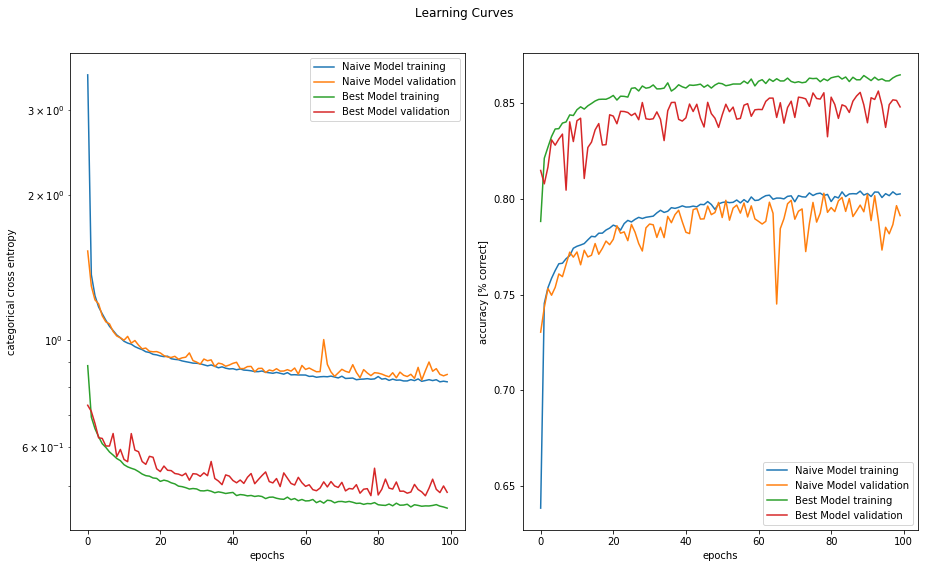

In [35]:
comparison_plot(histories[0], best_hist, 'Naive Model', 'Best Model', 'Learning Curves' );

Answer to question 2 (comments):

In [36]:
# Best Model 
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=x_train[0].shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l2()))
model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(), 
                                    kernel_regularizer = l2()))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                      optimizer=adm,
                      metrics=['accuracy'])

best_model_mnist = model.fit(x_train,y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=1, callbacks = None, validation_data = (x_test, y_test) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.7223 - acc: 0.8943 - val_loss: 0.5243 - val_acc: 0.9210
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5069 - acc: 0.9237 - val_loss: 0.4610 - val_acc: 0.9347
Epoch 3/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4562 - acc: 0.9312 - val_loss: 0.4242 - val_acc: 0.9379
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4256 - acc: 0.9369 - val_loss: 0.3916 - val_acc: 0.9442
Epoch 5/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4048 - acc: 0.9389 - val_loss: 0.3916 - val_acc: 0.9423
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3882 - acc: 0.9419 - val_loss: 0.3697 - val_acc: 0.9450
Epoch 7/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.3728 - acc: 0.9443 - val_loss: 0.3611 - 

60000/60000 [==============================] - 1s 23us/step - loss: 0.2183 - acc: 0.9670 - val_loss: 0.2159 - val_acc: 0.9679
Epoch 60/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2179 - acc: 0.9671 - val_loss: 0.2240 - val_acc: 0.9654
Epoch 61/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2136 - acc: 0.9679 - val_loss: 0.2193 - val_acc: 0.9650
Epoch 62/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2148 - acc: 0.9664 - val_loss: 0.2155 - val_acc: 0.9659A: 0s - loss: 0.2142 
Epoch 63/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2145 - acc: 0.9675 - val_loss: 0.2285 - val_acc: 0.9617
Epoch 64/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2176 - acc: 0.9663 - val_loss: 0.2054 - val_acc: 0.9699
Epoch 65/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2138 - acc: 0.9676 - val_loss: 0.2170 - val_acc: 0.9655
Epoch 66/100
60000/

In [37]:
plot_history(best_model_mnist, 'Deep Network Performance on MNIST');

(784,)

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

In [39]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [40]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],x_train.shape[2],1)/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1], x_fashion_train.shape[2],1)/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1], x_fashion_test.shape[2],1)/np.max(x_fashion_test)

In [41]:
def CNN_Image(nb_channels=10, dropoutRate = 0.5, act='relu', k_size=3, d_layer = 128, 
	k_regularizer = l2(0.001), in_shape= (28,28,1)) :
    """ 
    Deep convolutional 2D neural network with softmax classifier
    :param nb_channels: number of class
    :param dropoutRate: drop-out rate of last layer
    :param act: activation function
    :param k_size: convolutional kernel size
    :param k_regularizer: kernel regularizer
    :param d_layer: number of hidden unit in the last layer
    :param img_size: image size
    :param num_color_chan = number of color channel in the image
    :param input_dimension: size of the input 
 
   
   Conv2D<32> - Conv2D<32> - Conv2D<32> - Conv2D<32> - MaxPool2D<2,2> - 
   Conv2D<64> - Conv2D<64> - MaxPool2D<2,2> - 
   Conv2D<128> -  MaxPool2D<2,2> -
   Dense<512> - Dense<3>
   
    """
    strides = None
    print('PARAMETERS OF MODELS: ', act, ' ', k_size, ' ', d_layer, ' ', dropoutRate)

    # create model
    model = Sequential()
    # add layers
    model.add(Conv2D(32, kernel_size=k_size, input_shape= in_shape, 
    	kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer  ))
    model.add(Conv2D(32, kernel_size=k_size, padding='valid', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer) )
    #model.add(Conv2D(32, kernel_size=k_size, padding='same', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer) )
    #model.add(Conv2D(32, kernel_size=k_size, padding='same', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer) )
    model.add(MaxPooling2D(pool_size=(2, 2), strides=strides, padding='valid', data_format='channels_last'))
    #after max-pooling
    model.add(Conv2D(64, kernel_size=k_size, padding='valid', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer))
    #model.add(Conv2D(64, kernel_size=k_size, padding='same', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=strides, padding='valid', data_format='channels_last'))
    # another max-pooling
    #model.add(Conv2D(128, kernel_size=k_size, padding='same', kernel_initializer='glorot_uniform', activation=act, kernel_regularizer=k_regularizer))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=strides, padding='valid', data_format='channels_last'))
    # fully connected layer
    model.add(Flatten())
    model.add(Dense(d_layer))
    model.add(Dropout(rate=dropoutRate))
    model.add(Dense(nb_channels, activation='softmax'))
    
    return model

In [42]:
adm = Adam(lr = 0.001)
num_classes = 10
in_shape = x_fashion_train[0].shape
batch_size = 256
epochs = 10

dropoutRate = 0.5
acts= ['relu']
k_sizes= [3,5,7]
d_layers = [32,64,128]
k_regularizer = l2(0.001)

In [43]:
histories = []
models = []
for act in acts:
        for k_size in k_sizes:
            for d_layer in d_layers:
                model = CNN_Image(nb_channels=num_classes, dropoutRate = dropoutRate, act=act, k_size=k_size, d_layer = d_layer, 
                                   k_regularizer = k_regularizer)
                
                model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
                model.summary()
                hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
                histories.append(hist)
                models.append(model)

PARAMETERS OF MODELS:  relu   3   32   0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_94 (Dense)             (Non

60000/60000 [==============================] - 80s 1ms/step - loss: 0.0546 - acc: 0.9898 - val_loss: 0.0437 - val_acc: 0.9923
Epoch 6/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0504 - acc: 0.9903 - val_loss: 0.0415 - val_acc: 0.9925
Epoch 7/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0469 - acc: 0.9914 - val_loss: 0.0450 - val_acc: 0.9911
Epoch 8/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0446 - acc: 0.9916 - val_loss: 0.0413 - val_acc: 0.9923
Epoch 9/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0429 - acc: 0.9920 - val_loss: 0.0406 - val_acc: 0.9925
Epoch 10/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0409 - acc: 0.9926 - val_loss: 0.0394 - val_acc: 0.9925
PARAMETERS OF MODELS:  relu   5   32   0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Co

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 114s 2ms/step - loss: 0.2419 - acc: 0.9453 - val_loss: 0.0945 - val_acc: 0.9864
Epoch 2/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0943 - acc: 0.9843 - val_loss: 0.0693 - val_acc: 0.9893
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0749 - acc: 0.9877 - val_loss: 0.0592 - val_acc: 0.9903
Epoch 4/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0664 - acc: 0.9887 - val_loss: 0.0578 - val_acc: 0.9900
Epoch 5/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0588 - acc: 0.9904 - val_loss: 0.0519 - val_acc: 0.9916
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0559 - acc: 0.9907 - val_loss: 0.0557 - val_acc: 0.9907
Epoch 7/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0537 - acc: 0.9911 - val_loss: 0.0505 - 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 124s 2ms/step - loss: 0.2891 - acc: 0.9408 - val_loss: 0.1193 - val_acc: 0.9849
Epoch 2/10
60000/60000 [==============================] - 122s 2ms/step - loss: 0.1143 - acc: 0.9839 - val_loss: 0.0847 - val_acc: 0.9893
Epoch 3/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0917 - acc: 0.9865 - val_loss: 0.0763 - val_acc: 0.9890
Epoch 4/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0799 - acc: 0.9887 - val_loss: 0.0743 - val_acc: 0.9886
Epoch 5/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0750 - acc: 0.9895 - val_loss: 0.0660 - val_acc: 0.9915
Epoch 6/10
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0699 - acc: 0.9906 - val_loss: 0.0629 - val_acc: 0.9917
Epoch 7/10
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0665 - acc: 0.9909 - val_loss: 0.0625 - 

Answer to question 3:

In [44]:
acc =  [x.history['val_acc'][-1] for x in histories]
all_acc = np.concatenate([x.history['val_acc']for x in histories])
best_idx = np.argmax(acc)
best_hist = histories[best_idx]
best_model = models[best_idx]
best_k_size_idx = int(np.floor(best_idx / 3))
best_d_layer_idx = best_idx % 3
print('Best model kernel size: ', k_sizes[best_k_size_idx], ', dense layer neurons: ', d_layers[best_d_layer_idx])

Best model kernel size:  3 , dense layer neurons:  128


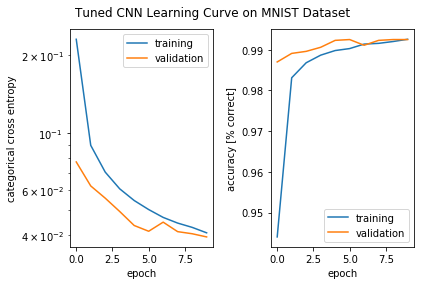

In [45]:
# Plot the learning curve for MNIST
plot_history(best_hist, 'Tuned CNN Learning Curve on MNIST Dataset');

In [46]:
# Train the Fashion MNIST dataset with the best parameters

model = CNN_Image(nb_channels=num_classes, dropoutRate = dropoutRate, act=act, 
                  k_size=k_sizes[best_k_size_idx], d_layer = d_layers[best_d_layer_idx], 
                   k_regularizer = k_regularizer)

model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
fashion_hist = model.fit(x_fashion_train, y_fashion_train, validation_data=(x_fashion_test, y_fashion_test),
                         epochs=epochs, batch_size=batch_size, verbose=1)

PARAMETERS OF MODELS:  relu   3   128   0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_112 (Dense)            (No

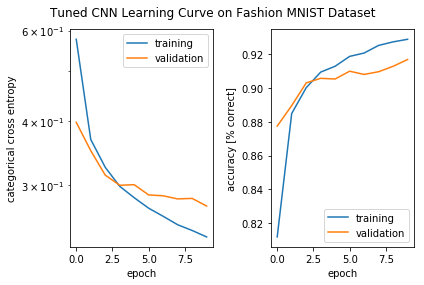

In [47]:
plot_history(fashion_hist, 'Tuned CNN Learning Curve on Fashion MNIST Dataset');

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Answer to question 1:

Answer to question 2: